- Code adopted from https://rguigoures.github.io/word2vec_pytorch/
- Relevant implementation: https://github.com/Andras7/word2vec-pytorch

In [1]:
import itertools
import re
import gc
import nltk

from nltk.corpus import stopwords
from tqdm.notebook import tqdm, trange
import networkx as nx
from scipy import sparse
import numpy as np
import pandas as pd
import pygsp

from sklearn import cluster
from sklearn.manifold import SpectralEmbedding
import matplotlib.pyplot as plt

import torch
from torch import nn, autograd
import torch.optim as optim
import torch.nn.functional as F

%config Completer.use_jedi = False

dev = 'cuda:0'

In [2]:
from collections import Counter, defaultdict
import random, math
from numpy.random import multinomial
from sklearn import neighbors

def subsample_frequent_words(corpus, word_counts=None):
    filtered_corpus = []
    if word_counts is None:
        word_counts = dict(Counter(list(itertools.chain.from_iterable(corpus))))
    sum_word_counts = sum(list(word_counts.values()))
    word_counts = {w: cnt / float(sum_word_counts) for w,cnt in word_counts.items()}
    for text in tqdm(corpus):
        filtered_corpus.append([])
        for word in text:
            if random.random() < (1 + math.sqrt(word_counts[word] * 1e3)) * 1e-3 / float(word_counts[word]):
                filtered_corpus[-1].append(word)
    return filtered_corpus


def get_batches(context_tuple_list, batch_size=100):
    random.shuffle(context_tuple_list)
    batches = []
    batch_target, batch_context, batch_negative = [], [], []
    for i,ctup in enumerate(context_tuple_list):
        batch_target.append(word_to_index[ctup[0]])
        batch_context.append(word_to_index[ctup[1]])
        if len(ctup) > 2:
            batch_negative.append([word_to_index[w] for w in ctup[2]])
        if (i+1) % batch_size == 0 or i == len(context_tuple_list)-1:
            tensor_target = autograd.Variable(torch.from_numpy(np.array(batch_target)).long())
            tensor_context = autograd.Variable(torch.from_numpy(np.array(batch_context)).long())
            if len(ctup) > 2:
                tensor_negative = autograd.Variable(torch.from_numpy(np.array(batch_negative)).long())
                batches.append((tensor_target, tensor_context, tensor_negative))
            else:
                batches.append((tensor_target, tensor_context))
            
            batch_target, batch_context, batch_negative = [], [], []
    return batches


class EarlyStopping():
    def __init__(self, patience=5, min_percent_gain=0.1):
        self.patience = patience
        self.loss_list = []
        self.min_percent_gain = min_percent_gain / 100.
        
    def update_loss(self, loss):
        self.loss_list.append(loss)
        if len(self.loss_list) > self.patience:
            del self.loss_list[0]
    
    def stop_training(self):
        if len(self.loss_list) == 1:
            return False
        gain = (max(self.loss_list) - min(self.loss_list)) / max(self.loss_list)
        print("Loss gain: {}%".format(round(100*gain,2)))
        if gain < self.min_percent_gain:
            return True
        else:
            return False
        
        
def create_graph_from_embedding(embedding, name, k=10):
    latent_dim, batch_size = embedding.shape
    if name =='gaussian':
        # Compute a gaussian kernel over the node activations
        node_distances = squareform(pdist(embedding, 'sqeuclidean'))
        s = 1
        K = np.exp(-node_distances / s**2)
        K[K < 0.1] = 0
        A = K * (np.ones((latent_dim, latent_dim)) - np.identity(latent_dim))
        return A
    elif name == 'knn':
        mat = neighbors.kneighbors_graph(embedding, n_neighbors=k, metric='cosine', mode='distance')
        mat.data = 1 - mat.data
        A = mat.toarray()
#         A = neighbors.kneighbors_graph(embedding, n_neighbors=k, metric='cosine').toarray()
        A = (A + A.T) / 2 # Symmetrize knn graph
        return A
    elif name == 'adaptive':
        # Find distance of k-th nearest neighbor and set as bandwidth
        neigh = neighbors.NearestNeighbors(n_neighbors=3)
        neigh.fit(embedding)
        dist, _ = neigh.kneighbors(embedding, return_distance=True)
        kdist = dist[:,-1]
        # Apply gaussian kernel with adaptive bandwidth
        node_distances = squareform(pdist(embedding, 'sqeuclidean'))
        K = np.exp(-node_distances / kdist**2)
        A = K * (np.ones((latent_dim, latent_dim)) - np.identity(latent_dim))
        A = (A + np.transpose(A)) / 2 # Symmetrize knn graph
        return A
    else:
        raise RuntimeError('Unknown graph name %s' % name)

In [4]:
# %time documents_norm = pd.read_pickle("../DocumentMap/arxiv/cache/documents_norm_all.pkl")

CPU times: user 24.6 s, sys: 4.73 s, total: 29.3 s
Wall time: 32.2 s


In [5]:
# word_counts = defaultdict(lambda: 0)
# for words in tqdm(documents_norm):
#     for w in words:
#         word_counts[w] += 1
    
# word_counts = pd.Series(word_counts)

# vocabulary = set(word_counts.index.values[word_counts.values >= 10]) - set(stopwords.words('english'))
# word_counts = word_counts[list(vocabulary)]
# word_counts.to_pickle("./cache/word_counts_arxiv.pkl")

# len(vocabulary)

  0%|          | 0/3638214 [00:00<?, ?it/s]

107727

In [3]:
word_counts = pd.read_pickle("./cache/word_counts_arxiv.pkl")
vocabulary = set(word_counts.index)

In [6]:
# corpus = [[w for w in words if w in vocabulary] for words in tqdm(documents_norm)]
# corpus = subsample_frequent_words(corpus, word_counts=dict(word_counts))
# corpus = [t for t in corpus if len(t) > 4]

  0%|          | 0/3638214 [00:00<?, ?it/s]

  0%|          | 0/3638214 [00:00<?, ?it/s]

In [9]:
# word_to_index = {w: idx for (idx, w) in enumerate(vocabulary)}
# index_to_word = np.array(list(vocabulary))

# sample_probability = (word_counts**0.75) / (word_counts**0.75).sum()
# sample_probability.index = [word_to_index[w] for w in sample_probability.index.values]

# pd.to_pickle((sample_probability, word_to_index, index_to_word), "./cache/w2v_meta_info.pkl")

In [4]:
sample_probability, word_to_index, index_to_word = pd.read_pickle("./cache/w2v_meta_info.pkl")

## Basic

In [11]:
class Word2Vec(nn.Module):

    def __init__(self, embedding_size, vocab_size):
        super(Word2Vec, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        self.linear = nn.Linear(embedding_size, vocab_size)
        
    def forward(self, context_word):
        emb = self.embeddings(context_word)
        hidden = self.linear(emb)
        out = F.log_softmax(hidden)
        return out

In [12]:
import numpy as np

context_tuple_list = []
w = 4

for text in corpus:
    for i, word in enumerate(text):
        first_context_word_index = max(0,i-w)
        last_context_word_index = min(i+w, len(text))
        for j in range(first_context_word_index, last_context_word_index):
            if i!=j:
                context_tuple_list.append((word, text[j]))
print("There are {} pairs of target and context words".format(len(context_tuple_list)))

There are 348617 pairs of target and context words


In [13]:
import gc
def clean_mem():
    gc.collect()
    torch.cuda.empty_cache()

In [16]:
%%time

vocabulary_size = len(vocabulary)

loss_function = nn.CrossEntropyLoss()
net = Word2Vec(embedding_size=225, vocab_size=vocabulary_size).to(dev)
optimizer = optim.Adam(net.parameters())
early_stopping = EarlyStopping(patience=5, min_percent_gain=1)

for ep in range(40):
    losses = []
    graph_losses = []
    context_tuple_batches = get_batches(context_tuple_list, batch_size=1000)
    for i in trange(len(context_tuple_batches)):
#     for i in range(len(context_tuple_batches)):
        activations = []
        net.zero_grad()
        target_tensor, context_tensor = context_tuple_batches[i]
        target_tensor, context_tensor = target_tensor.to(dev), context_tensor.to(dev)
        log_probs = net(context_tensor)
        loss = loss_function(log_probs, target_tensor)

#         gl = graph_loss(activations[-1], lap_torch) * 1.0
#         graph_losses.append(gl.data.item())
        losses.append(loss.data.item())
        
#         loss += gl

        loss.backward()
        optimizer.step()
    del loss, target_tensor, context_tensor, log_probs
    clean_mem()

    print("Epoch: ", ep, ". Loss: ", np.mean(losses))
#     print("Epocj: ", ep, ". Loss: ", np.mean(losses), ". Graph loss: ", np.mean(graph_losses))
    early_stopping.update_loss(np.mean(losses))
    if early_stopping.stop_training():
        break

  0%|          | 0/349 [00:00<?, ?it/s]

<ipython-input-11-1b84e6671fcd>:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(hidden)


Epoch:  0 . Loss:  9.320434086643864


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  1 . Loss:  8.47007752011362
Loss gain: 9.12%


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  2 . Loss:  7.7793624776823815
Loss gain: 16.53%


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  3 . Loss:  7.27933283726602
Loss gain: 21.9%


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  4 . Loss:  6.897174399356787
Loss gain: 26.0%


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  5 . Loss:  6.595392617933388
Loss gain: 22.13%


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  6 . Loss:  6.355208857353232
Loss gain: 18.31%


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  7 . Loss:  6.1623873847261885
Loss gain: 15.34%


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  8 . Loss:  6.004955484395724
Loss gain: 12.94%


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  9 . Loss:  5.873008282614984
Loss gain: 10.95%


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  10 . Loss:  5.760861564843907
Loss gain: 9.35%


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  11 . Loss:  5.663851270702985
Loss gain: 8.09%


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  12 . Loss:  5.5794048555259375
Loss gain: 7.09%


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  13 . Loss:  5.504068257132369
Loss gain: 6.28%


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  14 . Loss:  5.437409077127889
Loss gain: 5.61%


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  15 . Loss:  5.376955841195618
Loss gain: 5.07%


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  16 . Loss:  5.322566000984869
Loss gain: 4.6%


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  17 . Loss:  5.272647665018338
Loss gain: 4.2%


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  18 . Loss:  5.227473424293933
Loss gain: 3.86%


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  19 . Loss:  5.185552823850965
Loss gain: 3.56%


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  20 . Loss:  5.147435363179292
Loss gain: 3.29%


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  21 . Loss:  5.11157504603651
Loss gain: 3.05%


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  22 . Loss:  5.078732640832065
Loss gain: 2.85%


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  23 . Loss:  5.048060899477633
Loss gain: 2.65%


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  24 . Loss:  5.01964980073508
Loss gain: 2.48%


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  25 . Loss:  4.992918517323141
Loss gain: 2.32%


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  26 . Loss:  4.967985448318088
Loss gain: 2.18%


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  27 . Loss:  4.94468376219785
Loss gain: 2.05%


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  28 . Loss:  4.9227856141448365
Loss gain: 1.93%


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  29 . Loss:  4.902128961502993
Loss gain: 1.82%


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  30 . Loss:  4.883149294593614
Loss gain: 1.71%


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  31 . Loss:  4.864517653227535
Loss gain: 1.62%


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  32 . Loss:  4.847328140947402
Loss gain: 1.53%


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  33 . Loss:  4.831198835782813
Loss gain: 1.45%


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  34 . Loss:  4.815907802144572
Loss gain: 1.38%


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  35 . Loss:  4.801674863328906
Loss gain: 1.29%


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  36 . Loss:  4.787580226417258
Loss gain: 1.23%


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  37 . Loss:  4.774741381833752
Loss gain: 1.17%


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  38 . Loss:  4.762423934772568
Loss gain: 1.11%


  0%|          | 0/349 [00:00<?, ?it/s]

Epoch:  39 . Loss:  4.750629777553089
Loss gain: 1.06%
CPU times: user 8min 31s, sys: 5.74 s, total: 8min 37s
Wall time: 8min 42s


In [17]:
def get_closest_word(word, topn=5):
    word_distance = []
    emb = net.embeddings
    pdist = nn.PairwiseDistance()
    i = word_to_index[word]
    lookup_tensor_i = torch.tensor([i], dtype=torch.long).to(dev)
    v_i = emb(lookup_tensor_i)
#     sw = set(stopwords.words('english'))
    for j in range(len(vocabulary)):
        if j != i:
            lookup_tensor_j = torch.tensor([j], dtype=torch.long).to(dev)
            v_j = emb(lookup_tensor_j)
            w_j = index_to_word[j]
#             if w_j in sw:
#                 continue
            word_distance.append((w_j, float(pdist(v_i, v_j))))
    word_distance.sort(key=lambda x: x[1])
    return word_distance[:topn]

In [32]:
get_closest_word('president', 10)

[('fleisher', 18.722606658935547),
 ('enlarge', 18.83080291748047),
 ('brain', 18.929447174072266),
 ('outclassed', 18.946792602539062),
 ('bandstand', 18.9520206451416),
 ('governs', 19.096294403076172),
 ('friends', 19.102394104003906),
 ('freida', 19.13754653930664),
 ('adverse', 19.1530818939209),
 ('dillon', 19.16147232055664)]

## Optimized

Would be cool to train an embedding, which checks what words can be presented in any place. Perhaps, prediction quality should be a reasonable metric.

In [12]:
# w = 4

# ids = np.arange(len(corpus), dtype=int)
# np.random.shuffle(ids)
# targ_lst = []
# cont_lst = []

# for ti in tqdm(ids):
#     text = corpus[ti]
#     for i, word in enumerate(text):
#         first_context_word_index = max(0,i-w)
#         last_context_word_index = min(i+w, len(text))
#         for j in range(first_context_word_index, last_context_word_index):
#             if i!=j:
#                 targ_lst.append(word_to_index[word])
#                 cont_lst.append(word_to_index[text[j]])
# print("There are {} pairs of target and context words".format(len(cont_lst)))
# targ_lst = np.array(targ_lst)
# cont_lst = np.array(cont_lst)

# %time pd.to_pickle((targ_lst, cont_lst), "./cache/context_tuple_list_arxiv.pkl")

  0%|          | 0/3367021 [00:00<?, ?it/s]

There are 1031838297 pairs of target and context words
CPU times: user 30.5 ms, sys: 17.9 s, total: 17.9 s
Wall time: 18.3 s


In [5]:
%time targ_lst, cont_lst = pd.read_pickle("./cache/context_tuple_list_arxiv.pkl")

CPU times: user 353 µs, sys: 6.02 s, total: 6.02 s
Wall time: 6.04 s


In [6]:
pd.value_counts(index_to_word[cont_lst[targ_lst == word_to_index["graph"]]])[:15]

graph        35021
vertex       16969
edge         12273
number       10956
random       10779
network       9949
problem       9687
set           7987
connected     7300
class         7221
algorithm     7144
based         6576
given         6329
show          6264
complete      6246
dtype: int64

In [23]:
class Word2Vec(nn.Module):

    def __init__(self, embedding_size, vocab_size):
        super(Word2Vec, self).__init__()
        self.embeddings_target = nn.Embedding(vocab_size, embedding_size)
        self.embeddings_context = nn.Embedding(vocab_size, embedding_size)
#         embeddings_target = nn.Embedding(vocab_size, embedding_size)
#         embeddings_context = nn.Embedding(vocab_size, embedding_size)

#         self.embeddings_context = nn.Embedding(vocab_size, embedding_size, _weight=embeddings_context.weight.to(dtype=torch.half))
#         self.embeddings_target = nn.Embedding(vocab_size, embedding_size, _weight=embeddings_target.weight.to(dtype=torch.half))

    def forward(self, target_word, context_word, negative_example):
        emb_target = self.embeddings_target(target_word)
        emb_context = self.embeddings_context(context_word)
        emb_product = torch.mul(emb_target, emb_context)
        emb_product = torch.sum(emb_product, dim=1)
        out = torch.sum(F.logsigmoid(emb_product))
        emb_negative = self.embeddings_context(negative_example)
        emb_product = torch.bmm(emb_negative, emb_target.unsqueeze(2))
        emb_product = torch.sum(emb_product, dim=1)
        out += torch.sum(F.logsigmoid(-emb_product))
        return -out

def graph_loss(activations, lap):
    return (activations.mm(lap) * activations).sum() / activations.shape[1]

### Basic word2vec

In [27]:
del loss, losses, optimizer, net
gc.collect()
torch.cuda.empty_cache()

In [28]:
net = Word2Vec(embedding_size=22**2, vocab_size=len(vocabulary)).to(dev)
optimizer = optim.Adam(net.parameters())
batch_size = 25000

losses = []

In [29]:
%%time

p_iter = trange(0, targ_lst.size, batch_size)
for batch_start in p_iter:
    neg_words = np.random.choice(sample_probability.index.values, size=(min(len(targ_lst) - batch_start, batch_size), 5), p=sample_probability.values)
    target_tensor = torch.from_numpy(targ_lst[batch_start:(batch_start + batch_size)]).long().to(dev)
    context_tensor = torch.from_numpy(cont_lst[batch_start:(batch_start + batch_size)]).long().to(dev)
    neg_tensor = torch.from_numpy(neg_words).long().to(dev)

    net.zero_grad()
    loss = net(target_tensor, context_tensor, neg_tensor)
    losses.append(loss.data.item())

    loss.backward()
    optimizer.step()

    p_iter.set_postfix({"loss": np.round(losses[-1])})

  0%|          | 0/41274 [00:00<?, ?it/s]

CPU times: user 2h 59min 29s, sys: 11.8 s, total: 2h 59min 41s
Wall time: 2h 59min 51s


In [31]:
# torch.save(net.cpu(), "./models/w2v_arxiv.pkl")
torch.save(net.state_dict(), "./models/w2v_arxiv_state_484.pth")

In [32]:
net = net.cpu();

activations = []
dict(net.named_modules())['embeddings_target'].register_forward_hook(lambda mod, inp, out: activations.append(out.cpu()));

In [33]:
activations = []
lookup_table = {k: net.embeddings_target(torch.tensor([word_to_index[k]], dtype=torch.long)).detach().numpy() for k in tqdm(vocabulary)}
lookup_table = pd.Series(lookup_table)[vocabulary]
emb_mat = np.concatenate(lookup_table.values)

joint_activations = torch.vstack(activations).detach().numpy()
adj_mat = create_graph_from_embedding(joint_activations.T, 'knn')

  0%|          | 0/107727 [00:00<?, ?it/s]

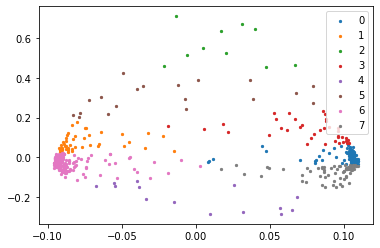

In [34]:
spec_emb = SpectralEmbedding(affinity='precomputed').fit_transform(adj_mat)
clust_labels = cluster.k_means(spec_emb, 8)[1]

for i in set(clust_labels):
    mask = (clust_labels == i)
    plt.scatter(spec_emb[mask,0], spec_emb[mask,1], s=5, label=i)
plt.legend();

### Graph-regularized (grid)

In [33]:
lap_csr = nx.linalg.normalized_laplacian_matrix(nx.grid_graph((15, 15)))
# coo = sparse.coo_matrix(lap_csr)
# values = coo.data
# indices = np.vstack((coo.row, coo.col))

# lap_torch = torch.sparse.FloatTensor(torch.LongTensor(indices), torch.FloatTensor(values), torch.Size(coo.shape))

lap_torch = torch.Tensor(lap_csr.A)

In [39]:
%%time

net_graph = Word2Vec(embedding_size=225, vocab_size=len(vocabulary)).to(dev)
optimizer = optim.Adam(net_graph.parameters())
batch_size = 25000

activations = []
dict(net_graph.named_modules())['embeddings_target'].register_forward_hook(lambda mod, inp, out: activations.append(out.cpu()));

losses = []
graph_losses = []
p_iter = trange(0, targ_lst.size, batch_size)
for batch_start in p_iter:
    neg_words = np.random.choice(sample_probability.index.values, size=(min(len(targ_lst) - batch_start, batch_size), 5), p=sample_probability.values)
    target_tensor, context_tensor, neg_tensor = [torch.from_numpy(x).long().to(dev) for x in (targ_lst[batch_start:(batch_start + batch_size)], cont_lst[batch_start:(batch_start + batch_size)], neg_words)]

    activations = []
    net_graph.zero_grad()
    loss = net_graph(target_tensor, context_tensor, neg_tensor)

    gl = graph_loss(activations[-1], lap_torch) * 10.0
    graph_losses.append(gl.data.item())
    losses.append(loss.data.item())
    loss += gl

    loss.backward()
    optimizer.step()
    p_iter.set_postfix({"loss": np.round(losses[-1]), "graph": np.round(graph_losses[-1])})

  0%|          | 0/41274 [00:00<?, ?it/s]

CPU times: user 5h 45min 14s, sys: 12min 36s, total: 5h 57min 50s
Wall time: 1h 41min 53s


In [87]:
torch.save(net_graph.state_dict(), "./models/w2v_arxiv_graph_state.pth")

In [40]:
import matplotlib.pyplot as plt

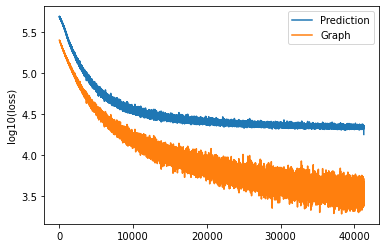

In [41]:
plt.plot(np.log10(losses), label="Prediction")
plt.plot(np.log10(graph_losses), label="Graph")
plt.ylabel("log10(loss)")
plt.legend();

#### Evaluation

In [42]:
from sklearn.metrics import pairwise
import seaborn as sns

In [43]:
net_graph = net_graph.cpu();
net = net.cpu();

In [68]:
lookup_table_graph = {k: net_graph.embeddings_target(torch.tensor([word_to_index[k]], dtype=torch.long)).detach().numpy() for k in tqdm(vocabulary)}
lookup_table_graph = pd.Series(lookup_table_graph)[vocabulary]
lookup_table = {k: net.embeddings_target(torch.tensor([word_to_index[k]], dtype=torch.long)).detach().numpy() for k in tqdm(vocabulary)}
lookup_table = pd.Series(lookup_table)[vocabulary]

emb_mat_graph = np.concatenate(lookup_table_graph.values)
emb_mat = np.concatenate(lookup_table.values)

  0%|          | 0/107727 [00:00<?, ?it/s]

  0%|          | 0/107727 [00:00<?, ?it/s]

In [31]:
lookup_table.index.values[pairwise.cosine_similarity(emb_mat, lookup_table['paper']).flatten().argsort()[::-1][:5]]

array(['paper', 'article', 'work', 'idea', 'aim'], dtype=object)

In [46]:
lookup_table.index.values[pairwise.cosine_similarity(emb_mat, lookup_table['paper']).flatten().argsort()[::-1][:5]]

array(['paper', 'article', 'work', 'idea', 'concept'], dtype=object)

In [58]:
lookup_table.index.values[pairwise.cosine_similarity(emb_mat, lookup_table['man']).flatten().argsort()[::-1][:5]]

array(['man', 'conflicting', 'geographic', 'inspect', 'abnormal'],
      dtype=object)

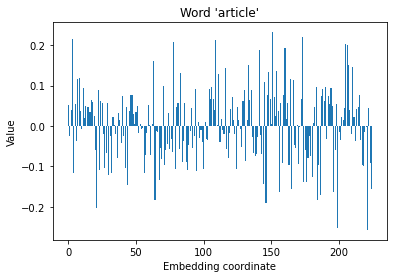

In [77]:
plt.bar(np.arange(225), lookup_table["article"].flatten())
plt.xlabel("Embedding coordinate"); plt.ylabel("Value"); plt.title("Word 'article'");

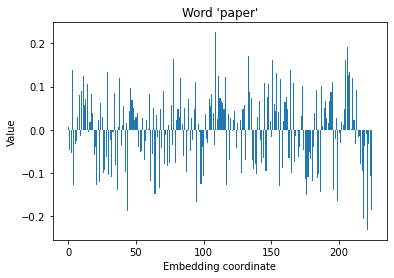

In [78]:
plt.bar(np.arange(225), lookup_table["paper"].flatten())
plt.xlabel("Embedding coordinate"); plt.ylabel("Value"); plt.title("Word 'paper'");

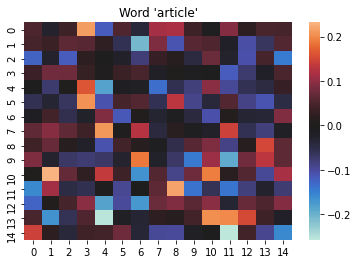

In [79]:
sns.heatmap(lookup_table["article"].reshape(15, 15), center=0);
plt.title("Word 'article'");

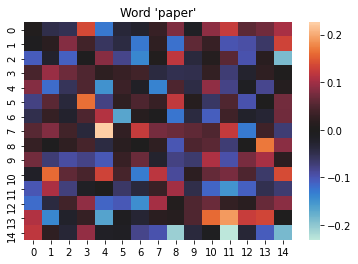

In [80]:
sns.heatmap(lookup_table["paper"].reshape(15, 15), center=0);
plt.title("Word 'paper'");

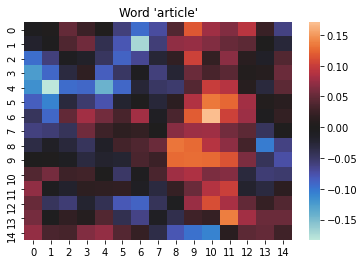

In [84]:
sns.heatmap(lookup_table_graph["article"].reshape(15, 15), center=0)
plt.title("Word 'article'");

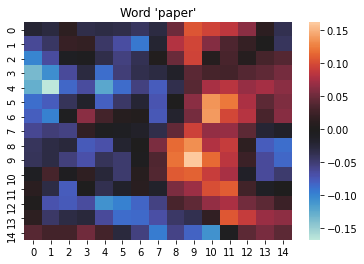

In [86]:
sns.heatmap(lookup_table_graph["paper"].reshape(15, 15), center=0)
plt.title("Word 'paper'");

<AxesSubplot:>

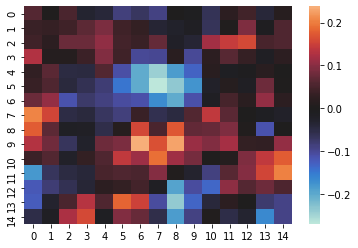

In [65]:
sns.heatmap(lookup_table["neuron"].reshape(15, 15), center=0)

<AxesSubplot:>

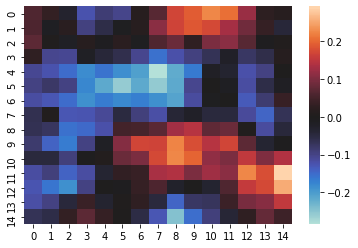

In [67]:
sns.heatmap(lookup_table["neural"].reshape(15, 15), center=0)

### Grap-regularized (k-NN)

In [102]:
%%time

net_graph = Word2Vec(embedding_size=225, vocab_size=len(vocabulary)).to(dev)
optimizer = optim.Adam(net_graph.parameters())
batch_size = 25000

activations = []
dict(net_graph.named_modules())['embeddings_target'].register_forward_hook(lambda mod, inp, out: activations.append(out.cpu()));

lap = None
losses = []
graph_losses = []
p_iter = trange(0, targ_lst.size, batch_size)
for i,batch_start in enumerate(p_iter):
    neg_words = np.random.choice(sample_probability.index.values, size=(min(len(targ_lst) - batch_start, batch_size), 5), p=sample_probability.values)
    target_tensor, context_tensor, neg_tensor = [torch.from_numpy(x).long().to(dev) for x in (targ_lst[batch_start:(batch_start + batch_size)], cont_lst[batch_start:(batch_start + batch_size)], neg_words)]

    net_graph.zero_grad()
    loss = net_graph(target_tensor, context_tensor, neg_tensor)
    
    losses.append(loss.data.item())
    if lap is not None:
        gl = graph_loss(activations[-1], lap) * 10.0
        graph_losses.append(gl.data.item())
        loss += gl

    loss.backward()
    optimizer.step()

    if i > 1 and i % 100 == 0:
        joint_activations = torch.vstack(activations).detach().numpy()
        adj_mat = create_graph_from_embedding(joint_activations.T, 'knn')
        graph = pygsp.graphs.Graph(adj_mat)
        graph.compute_laplacian(lap_type='normalized')
        lap = torch.Tensor(graph.L.A)
        activations = []

    if len(graph_losses) > 0:
        p_iter.set_postfix({"loss": np.round(losses[-1]), "graph": np.round(graph_losses[-1])})
    else:
        p_iter.set_postfix({"loss": np.round(losses[-1])})

  0%|          | 0/41274 [00:00<?, ?it/s]

CPU times: user 6h 52min 30s, sys: 20min 41s, total: 7h 13min 12s
Wall time: 2h 15min 26s


In [113]:
net_graph = net_graph.cpu();

In [134]:
activations = []
lookup_table_graph = {k: net_graph.embeddings_target(torch.tensor([word_to_index[k]], dtype=torch.long)).detach().numpy() for k in tqdm(vocabulary)}
lookup_table_graph = pd.Series(lookup_table_graph)[vocabulary]
emb_mat_graph = np.concatenate(lookup_table_graph.values)

  0%|          | 0/107727 [00:00<?, ?it/s]

In [136]:
joint_activations = torch.vstack(activations).detach().numpy()
adj_mat = create_graph_from_embedding(joint_activations.T, 'knn')

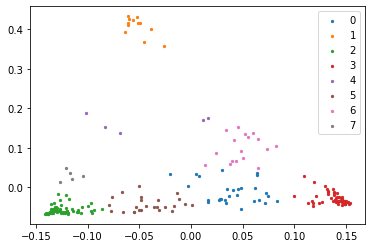

In [335]:
spec_emb = SpectralEmbedding(affinity='precomputed').fit_transform(adj_mat)
clust_labels = cluster.k_means(spec_emb, 8)[1]

for i in set(clust_labels):
    mask = (clust_labels == i)
    plt.scatter(spec_emb[mask,0], spec_emb[mask,1], s=5, label=i)
plt.legend();

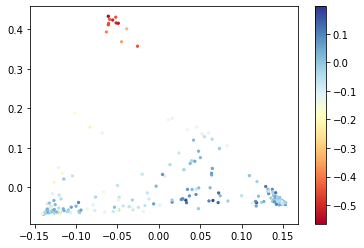

In [339]:
plt.scatter(spec_emb2[:,0], spec_emb2[:,1], c=lookup_table_graph["discourse"], s=5, cmap="RdYlBu")
plt.colorbar()

Clust 1:

In [336]:
lookup_table_graph.index.values[pairwise.cosine_similarity(emb_mat_graph, np.atleast_2d((clust_labels == 1).astype(float))).flatten().argsort()[::-1][:50]]

array(['1800', 'a_v', 'sim3', '650', '1700', 'sim0', 'agev', 'pwn', '12c',
       'gamma', 'sim1', 'sma', 'measured', '325', 'times10', 'qpo', '250',
       'fwhm', 'dayside', '253', 'pm0', 'angle', 'sin', 'rad',
       'unobscured', '200', 'kev', 'r_c', '240', 'qpos', 'sim',
       'periastron', '130', 'emissivity', 'hei', 'bepposax', '024', 'rms',
       'approx', 'crab', 'grs', 'flux', 'pseudorapidity', '320', 'circ',
       'gev', 'eruptive', '433', '127', '1200'], dtype=object)

In [338]:
lookup_table_graph.index.values[pairwise.cosine_similarity(emb_mat_graph, -np.atleast_2d((clust_labels == 1).astype(float))).flatten().argsort()[::-1][:50]]

array(['discourse', 'game', 'attentive', 'entity', 'agent', 'dialog',
       'social', 'commonsense', 'shared', 'language', 'formalized',
       'relational', 'spoken', 'premise', 'sdn', 'phrase',
       'informational', 'network', 'opinion', 'semantic', 'grounding',
       'learning', 'party', 'multiplex', 'vendor', 'curriculum',
       'graphical', 'sharing', 'attention', 'conversation', 'syntax',
       'semantics', 'contextual', 'editing', 'collaborative', 'ethical',
       'actor', 'tangible', 'reinforcement', 'textual', 'coined',
       'voting', 'logical', 'linguistic', 'dialogue', 'learn',
       'networked', 'harmful', 'learns', 'microgrids'], dtype=object)

In [337]:
lookup_table_graph.index.values[pairwise.euclidean_distances(emb_mat_graph, np.atleast_2d((clust_labels == 1) * 5)).flatten().argsort()[:50]]

array(['a_v', '1800', '433', 'sim3', 'agev', 'xmmu', 'rebrightening',
       'dayside', '293', '149', 'pwn', '024', 'nobeyama', 'emissivities',
       'flattens', 'passband', '303', 'mcdonald', '4686', '1700',
       'darkened', 'slsne', '253', 'southeast', 'unobscured', 'kilohertz',
       'hei', 'mrad', 'flyby', '083', '1510', 'serpens', '089', '036',
       '10m', '336', 'c18o', 'm_bh', '325', '0716', 'meteoritic', 'ska1',
       'lrg', 'proxima', 'gro', '1640', 't_l', 'femtobarns', 'plage',
       'superhump'], dtype=object)

Clust 2:

In [241]:
lookup_table_graph.index.values[pairwise.cosine_similarity(emb_mat_graph, np.atleast_2d((clust_labels == 2).astype(float))).flatten().argsort()[::-1][:50]]

array(['calculation', 'qcd', 'numerically', 'bottomonium', 'gluinos',
       'approximation', 'loewner', 'carlo', 'partonic', 'painleve',
       'nonrelativistic', 'monte', 'pitaevskii', 'full', 'dglap',
       'perturbative', 'cancelled', 'accommodates', 'exact', 'discarded',
       'hartree', 'subsampling', 'analytical', 'first', 'solution',
       'running', 'steepest', 'sudakov', 'theoretical', 'nesterov',
       'charmed', 'validity', 'holstein', 'result', 'psd', 'starting',
       'numerical', 'bethe', 'prediction', 'yes', 'schwinger', 'qed',
       'gribov', 'sherrington', 'staggered', 'ground', 'semiclassical',
       'idle', 'analytically', 'experimental'], dtype=object)

In [242]:
lookup_table_graph.index.values[pairwise.euclidean_distances(emb_mat_graph, np.atleast_2d((clust_labels == 2) * 5)).flatten().argsort()[:50]]

array(['nad', 'nonstrange', 'peakon', '3xmm', 'geometrodynamics',
       'projectability', 'acker', 'openacc', 'dsmc', 'inla', 'dyakonov',
       '2sc', 'meshing', 'approximator', 'qed3', 'qqbar', 'rmhd',
       'donder', 'nvt', 'savart', 'ramped', 'bssn', 'bertini', 'galform',
       'bgo', 'stuckelberg', 'penetrability', 'absorbtion',
       'electrodeposited', 'fcfs', 'vot2016', '0_l', 'mn', 'liapunov',
       'uchii', 'ge', 'semidiscrete', 'pais', 'icr', 'impure', 'nurbs',
       'exemplifying', 'uwb', 'antineutron', 'dokshitzer', 'gpe', 'wash',
       'cohomologically', 'lipatov', 'krook'], dtype=object)

Clust 3:

In [248]:
lookup_table_graph.index.values[pairwise.cosine_similarity(emb_mat_graph, np.atleast_2d((clust_labels == 3).astype(float))).flatten().argsort()[::-1][:50]]

array(['mst', 'comput', 'idle', 'mori', 'nvidia', 'rev', 'commun', 'doi',
       'browser', 'promotion', 'nobel', 'phys', '1981', 'que', 'lett',
       'chem', 'tanaka', 'uni', 'cuins', 'subsampling', 'proc', 'maple',
       'neuro', 'agreed', 'wang', 'alcohol', 'rfloor', 'begun', 'zhou',
       'typing', 'automate', 'lion', 'accommodates', 'complementing',
       'www', 'workspace', 'alcc', 'israel', 'granted', 'occasion',
       'lake', 'na', 'soap', 'euro', '1957', 'eom', 'aggregator',
       'inhibitor', 'lockdown', 'no_2'], dtype=object)

In [252]:
lookup_table_graph.index.values[pairwise.euclidean_distances(emb_mat_graph, np.atleast_2d((clust_labels == 3))).flatten().argsort()[:50]]

array(['mst', 'mori', 'nvidia', 'idle', 'comput', 'commun', 'browser',
       'promotion', 'doi', '1981', 'rev', 'uni', 'chem', 'phys', 'proc',
       'lett', 'agreed', 'maple', 'typing', 'begun', 'accommodates',
       'complementing', 'zhou', 'rfloor', 'www', 'wang', 'automate',
       'neuro', 'lake', 'israel', 'occasion', 'subsampling', 'psd',
       'lion', 'decided', 'tao', 'intel', 'workspace', 'algorithmically',
       'served', 'na', 'que', 'tanaka', 'sci', 'prl', 'preprint', 'cox',
       'appl', 'mathematica', '2010'], dtype=object)

In [227]:
# (emb_mat_graph * ((clust_labels == 2) * 2 - 1)).sum(axis=1)[(emb_mat_graph * ((clust_labels == 2) * 2 - 1)).sum(axis=1).argsort()[::-1]][:50]

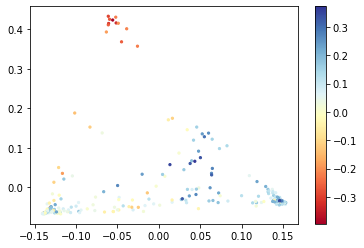

In [259]:
plt.scatter(spec_emb2[:,0], spec_emb2[:,1], c=lookup_table_graph["browser"], s=5, cmap="RdYlBu")
plt.colorbar()

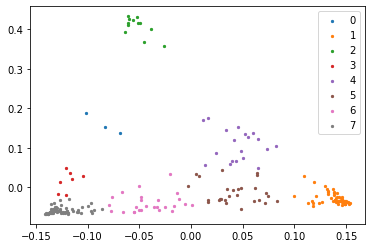

In [292]:
from sklearn import cluster

clust_labels = cluster.k_means(spec_emb2, 8)[1]

for i in set(clust_labels):
    mask = (clust_labels == i)
    plt.scatter(spec_emb2[mask,0], spec_emb2[mask,1], s=5, label=i)
plt.legend();

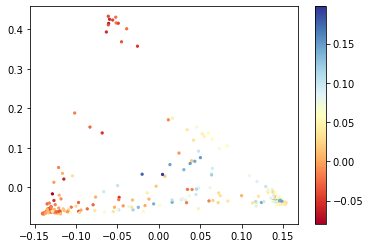

In [291]:
plt.scatter(spec_emb2[:,0], spec_emb2[:,1], c=lookup_table_graph["method"], s=5, cmap="RdYlBu")
plt.colorbar()

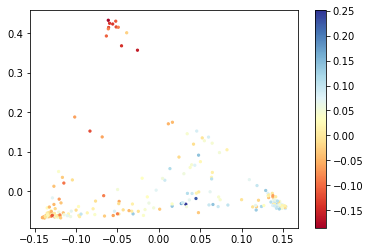

In [328]:
plt.scatter(spec_emb2[:,0], spec_emb2[:,1], c=lookup_table_graph["manuscript"], s=5, cmap="RdYlBu")
plt.colorbar()

In [325]:
# mask = (clust_labels == 3)
mask = ~np.in1d(clust_labels, [1])
lookup_table_graph.index.values[pairwise.cosine_similarity(emb_mat_graph[:,mask], lookup_table_graph['paper'][:,mask]).flatten().argsort()[::-1][1:20]]

array(['article', 'work', 'technical', 'algorithmic', 'purpose',
       'proposes', 'deal', 'concept', 'mathematical', 'symbolic',
       'prover', 'idea', 'tool', 'interactive', 'explores', 'formalize',
       'firstly', 'tackle', 'declarative'], dtype=object)

In [326]:
lookup_table_graph.index.values[pairwise.cosine_similarity(emb_mat_graph, lookup_table_graph['paper']).flatten().argsort()[::-1][1:20]]

array(['article', 'work', 'purpose', 'algorithmic', 'technical',
       'problem', 'idea', 'deal', 'formalization', 'concept',
       'mathematical', 'concise', 'firstly', 'devoted', 'manuscript',
       'motivating', 'new', 'thesis', 'conceptual'], dtype=object)

## Notes

- Can it be that each cluster is its own dimension? So we need to check how words change when values for the cluster nodes are moved from positive to negatives?
- What if we take a normal word2vec, estimate co-activations and build a graph? Will it be clustered?
- Probably, need to look at more dimensions than 2